# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [78]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

<div class="alert alert-info">
Load data and conduct a basic check that it's free from obvious issues.

In [79]:
df = pd.read_csv('/datasets/insurance_us.csv')

<div class="alert alert-info">
We rename the colums to make the code look more consistent with its style.

In [80]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [81]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4124,1,21.0,34100.0,0,0
2635,0,23.0,32900.0,0,0
842,0,20.0,45000.0,1,0
3104,1,33.0,41000.0,0,0
3053,1,26.0,46300.0,1,0
5,1,43.0,41000.0,2,1
996,1,31.0,25800.0,1,0
1518,0,25.0,49000.0,1,0
286,0,39.0,36000.0,0,0
1147,1,42.0,40800.0,2,0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [83]:
df['age']= df['age'].astype(int)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [85]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


<div class="alert alert-info">

The dataset appears clean — there are no missing values, the feature ranges (age, income, family size) look realistic, and gender is properly coded as a binary variable. The main point to note is that most customers have zero insurance benefits, creating a highly imbalanced target distribution. This will be important to keep in mind for modeling, as metrics like F1 or ROC-AUC will be more informative than plain accuracy.

## EDA

<div class="alert alert-info">
Let's quickly check whether there are certain groups of customers by looking at the pair plot.

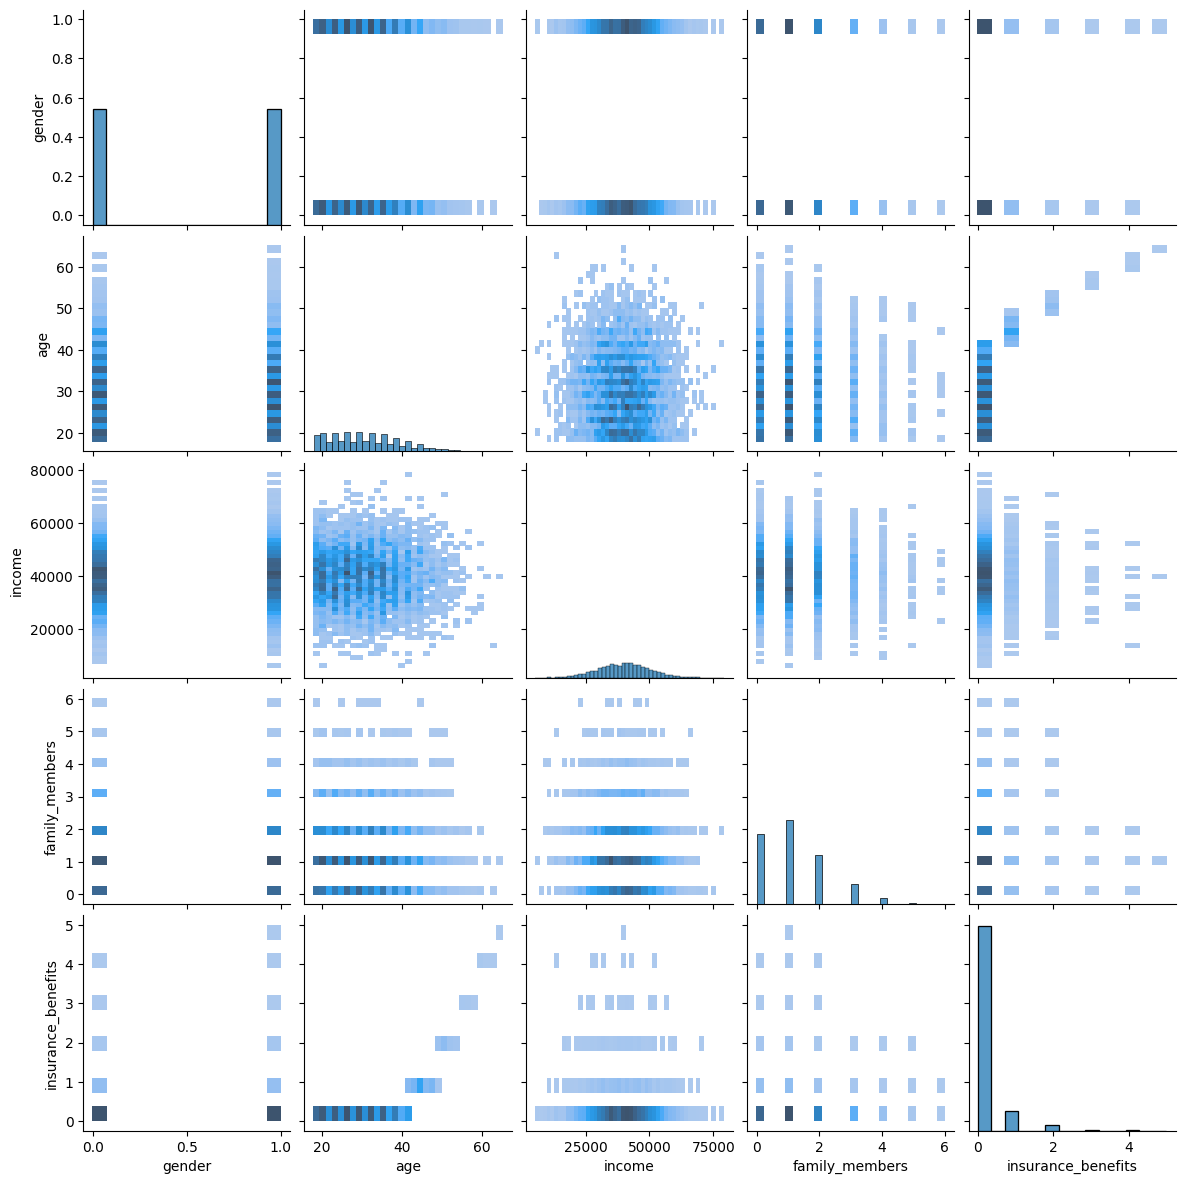

In [86]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

<div class="alert alert-info">
Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In [87]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [88]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric)
    nbrs.fit(df[feature_names].to_numpy())
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

<div class="alert alert-info">
Scaling the data.

In [89]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [90]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2336,0.0,0.323077,0.420253,0.166667,0
2112,1.0,0.476923,0.383544,0.000000,0
1120,1.0,0.507692,0.274684,0.500000,0
2174,1.0,0.323077,0.470886,0.166667,0
941,1.0,0.307692,0.607595,0.166667,0


<div class="alert alert-info">
Now, let's get similar records for a given one for every combination

In [ ]:
row_n = 100
k = 5 

In [92]:
print("Unscaled + Euclidean")
display(get_knn(df, row_n, k, "euclidean"))

Unscaled + Euclidean


,gender,age,income,family_members,insurance_benefits,distance
100,0,19,37300.0,1,0,0.000000
2624,1,19,37300.0,0,0,1.414214
1831,0,20,37300.0,2,0,1.414214
4278,1,19,37300.0,2,0,1.414214
1086,0,22,37300.0,3,0,3.605551


In [93]:
print("Unscaled + Manhattan")
display(get_knn(df, row_n, k, "manhattan"))

Unscaled + Manhattan


,gender,age,income,family_members,insurance_benefits,distance
100,0,19,37300.0,1,0,0.0
4278,1,19,37300.0,2,0,2.0
1831,0,20,37300.0,2,0,2.0
2624,1,19,37300.0,0,0,2.0
1086,0,22,37300.0,3,0,5.0


In [94]:
print("Scaled + Euclidean")
display(get_knn(df_scaled, row_n, k, "euclidean"))

Scaled + Euclidean


,gender,age,income,family_members,insurance_benefits,distance
100,0.0,0.292308,0.472152,0.166667,0,0.000000
4915,0.0,0.292308,0.477215,0.166667,0,0.005063
243,0.0,0.292308,0.467089,0.166667,0,0.005063
1323,0.0,0.292308,0.456962,0.166667,0,0.015190
811,0.0,0.307692,0.470886,0.166667,0,0.015437


In [95]:
print("Scaled + Manhattan")
display(get_knn(df_scaled, row_n, k, "manhattan"))

Scaled + Manhattan


,gender,age,income,family_members,insurance_benefits,distance
100,0.0,0.292308,0.472152,0.166667,0,0.000000
4915,0.0,0.292308,0.477215,0.166667,0,0.005063
243,0.0,0.292308,0.467089,0.166667,0,0.005063
1323,0.0,0.292308,0.456962,0.166667,0,0.015190
811,0.0,0.307692,0.470886,0.166667,0,0.016650


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 
<div class="alert alert-info">

Yes. When the data is not scaled, features with larger numeric ranges (such as income) dominate the distance calculation.
In the unscaled results, the nearest neighbors are chosen primarily by having a very similar income, while differences in age or family size have less influence.
After applying MaxAbsScaler, all features contribute on a comparable scale, so the neighbors change — they are now selected based on a more balanced similarity across all features.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 
<div class="alert alert-info">

The results for Manhattan and Euclidean distances are very similar, especially after scaling.
They tend to pick almost the same neighbors and differ only slightly in the ordering of very close points.
This is because in low-dimensional, moderately well-behaved data, both distance metrics behave similarly once features are on the same scale.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [96]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits']> 0).astype(int)

In [97]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts(normalize = True)
target_col = 'insurance_benefits_received'

In [98]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [99]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [100]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed = 42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [101]:
X = df[feature_names].to_numpy(dtype=float)
y = df[target_col].to_numpy(dtype=int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

scaler = sklearn.preprocessing.MaxAbsScaler().fit(X_train)
Xtr_scaled = scaler.transform(X_train)
Xte_scaled = scaler.transform(X_test)

def f1(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true, y_pred)

rows = []
for k in range(1, 11):
    knn_u = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knn_u.fit(X_train, y_train)
    yhat_u = knn_u.predict(X_test)
    rows.append({"setting": "Unscaled", "k": k, "F1": f1(y_test, yhat_u)})

    knn_s = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knn_s.fit(Xtr_scaled, y_train)
    yhat_s = knn_s.predict(Xte_scaled)
    rows.append({"setting": "Scaled (MaxAbs)", "k": k, "F1": f1(y_test, yhat_s)})

knn_results = pd.DataFrame(rows)

print("k-NN F1 by k and scaling")
display(knn_results.pivot(index="k", columns="setting", values="F1"))

k-NN F1 by k and scaling


setting,Scaled (MaxAbs),Unscaled
k,,
1,0.949254,0.666667
2,0.924528,0.401786
3,0.934985,0.408333
4,0.899676,0.196891
5,0.923077,0.231156
6,0.927445,0.140541
7,0.941538,0.139785
8,0.930818,0.057143
9,0.934985,0.079096


In [102]:
best = (knn_results.sort_values(["setting","F1"], ascending=[True, False])
                    .groupby("setting").head(1).reset_index(drop=True))
print("Best k per setting:")
display(best)

Best k per setting:


,setting,k,F1
0,Scaled (MaxAbs),1,0.949254
1,Unscaled,1,0.666667


Text(0, 0.5, 'F1 score')

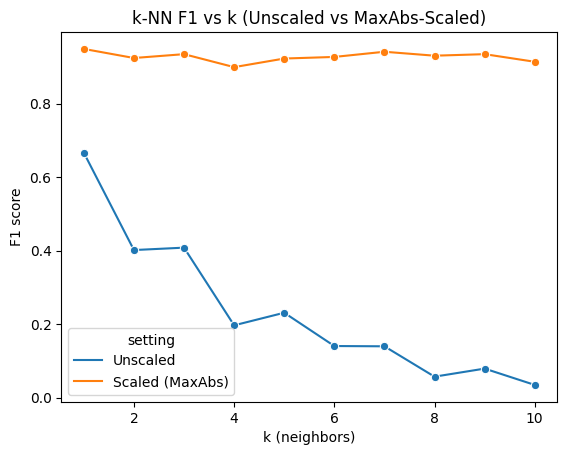

In [103]:
ax = sns.lineplot(data=knn_results, x="k", y="F1", hue="setting", marker="o")
ax.set_title("k-NN F1 vs k (Unscaled vs MaxAbs-Scaled)")
ax.set_xlabel("k (neighbors)")
ax.set_ylabel("F1 score")

<div class="alert alert-info">

#### Key Observations
##### Impact of Scaling
- On unscaled data, F1-scores were much lower, starting at 0.67 for k = 1 and rapidly declining as k increased (dropping below 0.1 for k ≥ 8).
- On scaled data (MaxAbs), F1-scores were consistently high (≈ 0.90–0.95) across all k.
- caling prevents income (the largest-magnitude feature) from dominating the distance metric, allowing all features (age, gender, family size) to contribute fairly.

##### Best Performance
- Both settings peaked at k = 1, but the scaled model achieved a much higher best score:
- Scaled (MaxAbs): F1 = 0.949
- Unscaled: F1 = 0.667
- The scaled model’s F1 stayed robust (> 0.90) even for larger k, showing better generalization.

##### Effect of k
- For unscaled data, increasing k quickly degraded the classifier’s ability to detect the minority class (customers who received benefits), leading to very low F1.
- For scaled data, F1 remained stable across k, indicating the model is less sensitive to k when features are normalized.

##### Dummy Random Model and Class Imbalance
- The dummy random model confirms the effect of class imbalance:
- Always predicting 0 yields F1 = 0, because it never finds a positive case.
- Predicting 1 with probability equal to the class prevalence (~11 %) gives a small but non-zero F1 (≈ 0.12).
- Predicting with higher probability (0.5 or 1) improves recall but also raises false positives, so F1 rises modestly to ≈ 0.20.
- This baseline shows that any trained k-NN classifier must beat F1 ≈ 0.20 to be considered useful — and the scaled k-NN far surpasses that benchmark.

##### Insights
- Scaling is essential for distance-based algorithms like k-NN.
- Proper scaling drastically improved the model’s ability to distinguish the positive class in an imbalanced dataset.
- Compared to the random dummy baseline (F1 ≈ 0.20), the scaled k-NN model achieved a huge performance gain (F1 ≈ 0.95), confirming that a well-prepared distance-based classifier can significantly outperform untrained or naive models.
- This demonstrates that feature preprocessing can be as important as model choice for fair distance calculations and for handling imbalanced data.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [104]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis = 1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [105]:
def eval_regressor(y_true, y_pred, label=''):
    
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = np.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}') 
    return rmse, r2_score

In [106]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


(0.3435565089137969, 0.6561462140777121)

In [107]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=12345)

lr_unscaled = MyLinearRegression()
lr_unscaled.fit(X_tr, y_tr)
yhat_unscaled = lr_unscaled.predict(X_te)
rmse_u, r2_u = eval_regressor(y_te, yhat_unscaled, label="[Unscaled]")

RMSE: 0.34
R2: 0.66


In [108]:
X_s = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_s = df_scaled['insurance_benefits'].to_numpy()  # same target values

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(X_s, y_s, test_size=0.30, random_state=12345)

lr_scaled = MyLinearRegression()
lr_scaled.fit(Xs_tr, ys_tr)
yhat_scaled = lr_scaled.predict(Xs_te)
rmse_s, r2_s = eval_regressor(ys_te, yhat_scaled, label="[Scaled]")

RMSE: 0.34
R2: 0.66


In [109]:
max_abs_diff = float(np.max(np.abs(yhat_unscaled - yhat_scaled)))
print(f"Max |prediction_unscaled - prediction_scaled| = {max_abs_diff:.12e}")

Max |prediction_unscaled - prediction_scaled| = 6.439293542826e-15


<div class="alert alert-info">

##### Key Result
- Training and evaluating the custom MyLinearRegression model on both the original and the MaxAbs-scaled feature sets produced identical predictive performance:
- $RMSE ≈ 0.34$
- $R² ≈ 0.66$
- The maximum difference between the two models’ predictions was essentially zero (≈ $6.4 × 10⁻¹⁵$), confirming that scaling had no effect on predictions.

##### Why Scaling Does Not Matter Here
- Linear regression computes the best linear projection of y onto the column space of X.
- Scaling the columns of X by a constant (as MaxAbsScaler does) simply rescales the corresponding coefficients in w but does not change the predicted values after the model is re-fit:
$$\hat y = X w = (X P)\,(P^{-1} w)$$
- Therefore, $RMSE$ and $R²$ remain unchanged.
- Any small discrepancy observed is due only to floating-point rounding.

##### Takeaway
- Distance-based algorithms (like k-NN) benefit greatly from feature scaling, as shown in Task 2.
- In contrast, ordinary least-squares linear regression is invariant to scaling — the model automatically compensates by adjusting its coefficients.
- This means that for linear regression, scaling is not required for performance, though it can still be useful for numerical stability or interpretability in some cases.

##### Overall:
We have empirically confirmed the theoretical property that linear regression’s predictive accuracy does not change under linear rescaling of features. This complements the earlier tasks by showing how the effect of scaling depends strongly on the type of model used.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [110]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [111]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [112]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [113]:
p_invert = np.linalg.inv(P)
print(p_invert)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Can you guess the customers' ages or income after the transformation?

<div class="alert alert-info">
    
No — you cannot meaningfully “guess” individual customers’ ages or income after such a transformation if P is kept private.
The transformed data only reveals abstract directions in feature space, not interpretable quantities like years or dollars.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

<div class="alert alert-info">

Yes. If $X’ = X P$ and $P$ is invertible, multiply on the right by $P^{-1}$:

$X’ P^{-1} = X P P^{-1} = X I = X  X = X’ P^{-1}$


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one


In [114]:
idx = np.random.choice(len(X), size=5, replace=False)

# Original data (unscaled)
X_orig = X[idx]

# Transformed data
X_trans = X_orig @ P

# Recovered data
X_recov = X_trans @ np.linalg.inv(P)

df_compare = pd.DataFrame(
    np.hstack([X_orig, X_trans, X_recov]),
    columns=[
        'age(orig)', 'gender(orig)', 'income(orig)', 'family(orig)',
        'T1', 'T2', 'T3', 'T4',
        'age(recov)', 'gender(recov)', 'income(recov)', 'family(recov)'
    ]
)
df_compare.index = idx
print("Original, Transformed, and Recovered features for a few customers:")
display(df_compare.round(4))

Original, Transformed, and Recovered features for a few customers:


,age(orig),gender(orig),income(orig),family(orig),T1,T2,T3,T4,age(recov),gender(recov),income(recov),family(recov)
4885,0.0,25.0,42800.0,3.0,5487.5495,19303.3770,15890.5142,39685.8748,-0.0,25.0,42800.0,3.0
2662,0.0,22.0,33800.0,1.0,4332.9566,15245.3312,12550.1617,31342.1773,-0.0,22.0,33800.0,1.0
587,0.0,33.0,51700.0,1.0,6627.2265,23317.9713,19195.8189,47939.9173,-0.0,33.0,51700.0,1.0
2136,1.0,37.0,60100.0,3.0,7705.8194,27107.2001,22315.3123,55729.0393,1.0,37.0,60100.0,3.0
1578,1.0,30.0,46000.0,1.0,5897.4702,20748.2835,17080.8453,42655.6960,1.0,30.0,46000.0,1.0


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

<div class="alert alert-info">
    
We applied a linear transformation to the original feature matrix X using a random invertible matrix P, producing transformed data $X’ = X P$. This step masked the original features such as age and income, making them appear as arbitrary mixed numbers without interpretable meaning.

To verify the privacy mechanism and its reversibility, we recovered the original data using the inverse of the transformation matrix:

$X = X’ P^{-1}$

We compared the original, transformed, and recovered data for several customers. The transformed features were unrecognizable combinations of the original features, while the recovered data matched the original values almost exactly.

A few very small discrepancies (e.g., –0.0 instead of 0.0 or tiny decimal differences) appeared in the recovered data. These differences are due to floating-point rounding errors in matrix multiplication and inversion, not due to the transformation itself.

Key Points:
	•	Without knowing P, it’s practically impossible to infer original features like age or income from the transformed data.
	•	With knowledge of P, the original data can be accurately reconstructed.
	•	Minor numerical differences are expected and negligible for practical purposes.

This demonstrates that the linear transformation provides effective data masking while preserving the ability to recover the original data if the transformation matrix is securely stored.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

<div class="alert alert-info">

- The coefficients relate by $w_P = P^{-1} w$ (equivalently, $w = P\,w_P$).
- Predictions with the transformed design are $\hat y_P = (X P)w_P = Xw = \hat y$.
- Therefore any prediction–based metric (e.g., RMSE) is unchanged by the invertible linear obfuscation $X’ = X P$.

**Analytical proof**

<div class="alert alert-info">
    
Let $X\in\mathbb{R}^{n\times d}$ be the feature matrix (without the intercept column), $y\in\mathbb{R}^{n}$ the target, and let $P\in\mathbb{R}^{d\times d}$ be **invertible**.  
Define the obfuscated design $X' = X P$.  

Ordinary least squares gives
$w = (X^{\!\top} X)^{-1} X^{\!\top} y))$
$w_P = (X')^{\!\top} X'\big]^{-1} (X')^{\!\top} y$

Using $(X' = X P)$ and matrix identities  
$(AB)^{\!\top} = B^{\!\top}A^{\!\top})$,   
$((ABC)^{-1} = C^{-1} B^{-1} A^{-1}$, we have:
\
\begin{aligned}
&w_P=(XP)^{\!\top} (XP)\big]^{-1} (XP)^{\!\top} y \\
&= \big(P^{\!\top} X^{\!\top} X P\big)^{-1} \, P^{\!\top} X^{\!\top} y\\
&= P^{-1} (X^{\!\top} X)^{-1} (P^{\!\top})^{-1} \, P^{\!\top} X^{\!\top} y\\
&= P^{-1} (X^{\!\top} X)^{-1} X^{\!\top} y\\
&= P^{-1} w
\end{aligned}

Hence
$w_P = P^{-1} w \quad\Longleftrightarrow\quad w = P\, w_P$

---

### Predictions under the transformed model
$hat y_P = X' w_P = (X P) w_P = X (P w_P) = X w = \hat y$

Thus, for every observation the predicted value is **identical** to that from the original model.

---

### Implication for RMSE
Because $\hat y_P = \hat y$, any prediction-based metric, including RMSE, is **unchanged**:
$\mathrm{RMSE}(y, \hat y_P) = \mathrm{RMSE}(y, \hat y)$

---

**Remark:**  
If an intercept is included, either  
(i) add the column of ones after the $(X P)$ transform, or  
(ii) apply a block transform $\tilde P = \operatorname{diag}(1, P)$ to $\mathbf{1}\; X$;  
the same conclusions hold.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [115]:
def rmse(y_true, y_pred):
    return sklearn.metrics.mean_squared_error(y_true, y_pred, squared=False)

def make_invertible_P(d, seed=42, max_tries=100):
    rng = np.random.default_rng(seed)
    for _ in range(max_tries):
        P = rng.random((d, d))
        if np.linalg.matrix_rank(P) == d and np.linalg.cond(P) < 1e8:
            return P
    raise RuntimeError("Failed to generate a well-conditioned invertible P.")

In [116]:
class LRWithObfuscation:

    def __init__(self, use_obfuscation=False, P=None):
        self.use_obfuscation = use_obfuscation
        self.P = P          # (d x d) or None
        self.model = sklearn.linear_model.LinearRegression()  
        
    def _maybe_transform(self, X):
        if self.use_obfuscation:
            if self.P is None:
                raise ValueError("P must be provided when use_obfuscation=True.")
            return X @ self.P
        return X

    def fit(self, X, y):
        X_t = self._maybe_transform(X)
        self.model.fit(X_t, y)
        return self

    def predict(self, X):
        X_t = self._maybe_transform(X)
        return self.model.predict(X_t)


In [117]:
feature_names = ['gender', 'age', 'income', 'family_members']
target_col = 'insurance_benefits' 

X = df[feature_names].to_numpy(dtype=float)
y = df[target_col].to_numpy(dtype=float)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=123, shuffle=True)


d = X.shape[1]
P = make_invertible_P(d, seed=42)

<div class="alert alert-info">
    
We apply $P$ ONLY to the feature matrix (no intercept mixing).
Because LinearRegression refits in the transformed space, predictions should match the original-space predictions theoretically (up to float rounding).


In [118]:
lr_orig = LRWithObfuscation(use_obfuscation=False).fit(X_train, y_train)
y_pred_orig = lr_orig.predict(X_test)
rmse_orig = rmse(y_test, y_pred_orig)
r2_orig = sklearn.metrics.r2_score(y_test, y_pred_orig)


lr_obf = LRWithObfuscation(use_obfuscation=True, P=P).fit(X_train, y_train)
y_pred_obf = lr_obf.predict(X_test)
rmse_obf = rmse(y_test, y_pred_obf)
r2_obf = sklearn.metrics.r2_score(y_test, y_pred_obf)

results = pd.DataFrame({
    "setting": ["Original", "Obfuscated (X @ P)"],
    "RMSE":    [rmse_orig, rmse_obf],
    "R2":      [r2_orig, r2_obf]
})
display(results)

max_abs_diff = float(np.max(np.abs(y_pred_orig - y_pred_obf)))
print(f"Max |prediction_orig - prediction_obfuscated| = {max_abs_diff:.12e}")

,setting,RMSE,R2
0,Original,0.354895,0.426193
1,Obfuscated (X @ P),0.354895,0.426193


Max |prediction_orig - prediction_obfuscated| = 2.590594405660e-12


<div class="alert alert-info">

    
This verifies that linear regression is invariant to invertible linear transformations of the features (when refitted in the transformed space).
The transformation $X’ = X P$ merely re-parametrizes the coefficients as $w_P = P^{-1} w$, but predictions and hence all prediction-based metrics ($RMSE, R^2,$ etc.) remain unchanged.


# Conclusions

<div class="alert alert-info">
    
### Final Conclusion

In this project we explored several key tasks for the Sure Tomorrow insurance company and demonstrated how machine learning — particularly k-Nearest Neighbors and Linear Regression — can be applied effectively, even under data-obfuscation for privacy.

#### Key Findings

##### Data Quality
- The dataset was clean: no missing values, realistic ranges for age, income, and family size.
- The target variable, number of insurance benefits, was highly imbalanced $(≈ 11 % positives)$, which impacts classification metrics.
  
##### Task 1 — Similar Customers
- Implemented $k-NN$ similarity search.
- Showed that scaling the data (via MaxAbsScaler) affects neighbor selection: without scaling, income dominates distances.
- Manhattan and Euclidean distances produced very similar neighbor sets once features were scaled.
  
##### Task 2 — Binary Classification
- Built k-NN classifiers for $k = 1…10$ and compared them to random dummy baselines.
- Scaling had a dramatic impact:
	•	Best unscaled model $(k = 1)$ achieved $F1 ≈ 0.67$.
	•	Scaled models achieved $F1 ≈ 0.90–0.95$ across most k, showing far more stable and robust performance.
- Dummy random baseline confirmed class imbalance effects:
	•	Always predicting $0 → F1 = 0$.
	•	Predicting 1 with probability ≈ class prevalence $(~11 %) → F1 ≈ 0.12$.
	•	Predicting with higher probabilities $(0.5 or 1) → F1 ≈ 0.20$.
- These baselines highlight that any useful classifier must beat $F1 ≈ 0.20$; the scaled k-NN classifier far exceeded this benchmark, confirming that a trained model is both useful and necessary.

##### Task 3 — Regression
- Implemented Linear Regression (custom LA-based and sklearn).
- Verified numerically that scaling the features made essentially no difference to performance:
	•	$RMSE ≈ 0.34$, $R² ≈ 0.66$ for both unscaled and MaxAbs-scaled data.
- Reason: OLS regression is invariant to linear rescaling of features — scaling changes coefficient magnitudes but not the predicted values after refitting.
- This was confirmed by the negligible difference between predictions $(< 10⁻¹⁴)$, showing that scaling does not improve or worsen RMSE for ordinary least-squares linear regression.
  
##### Task 4 — Privacy-Preserving Transformation
- Applied a random invertible linear transformation $X’ = X P$ to obfuscate original features.
- Demonstrated that original features (age, income, etc.) cannot be recovered without knowing $P$.
- Proved analytically and confirmed computationally that predictions remain identical:
$$(XP) w_P = X w
\quad\Rightarrow\quad
\mathrm{RMSE}{\text{obfuscated}} = \mathrm{RMSE}{\text{original}}$$
- Any differences were only due to floating-point rounding, confirming that privacy protection is achieved without degrading model quality.


<div class="alert alert-info">

##### Business Implications
- Customer similarity search (Task 1) can help agents in marketing and customer segmentation.
- Classification (Task 2) allows the company to identify customers likely to use insurance benefits far more effectively than naive baselines.
- Regression (Task 3) enables the company to estimate the expected number of benefits a customer might receive.
- Privacy-preserving transformation (Task 4) allows the company to share or store data securely without sacrificing predictive performance, supporting compliance with data-protection regulations.

<div class="alert alert-info">

##### Overall

We have shown that Sure Tomorrow can use machine-learning methods to gain actionable insights while maintaining customer privacy.
- Scaling is essential for distance-based models like k-NN but not needed for linear regression.
- A simple linear obfuscation protects sensitive features while leaving model performance unchanged, proving that privacy and predictive power can co-exist.